In [1]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import time
import matplotlib.pyplot as plt

/home/cudaq/.local/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/cudaq/.local/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/cudaq/.local/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [2]:
def build_circuit(n_qubits, depth, gate_params):
    """Build a quantum circuit and convert it to an MPO."""
    # Initialize the quantum circuit
    circuit = qtn.Circuit(n_qubits)

    for layer in range(depth):
        # Apply single-qubit RX rotations
        for i in range(n_qubits):
            theta = gate_params['single'][layer, i]
            circuit.apply_gate('rx', theta, i)

        # Apply two-qubit RZZ gates (nearest neighbors)
        for i in range(n_qubits - 1):
            for j in range(i+1, n_qubits):
                angle = gate_params['rzz'][layer, i, j]
                circuit.apply_gate('rzz', angle, i, j)

    for i in range(n_qubits):
        theta = gate_params['single'][depth-1, i]
        circuit.apply_gate('rx', depth-1, i)

    # Convert the circuit to an MPO
    #mpo = circuit.to_mpo()
    return circuit


(<Figure size 800x100 with 1 Axes>, <Axes: >)

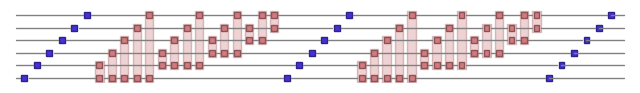

In [3]:
n_qubits = 6
depth = 2
params = {
    'single': np.random.uniform(0, 2*np.pi, (depth+1, n_qubits)),
    'rzz': np.random.uniform(0, 2*np.pi, (depth, n_qubits, n_qubits))
}

circuit = build_circuit(n_qubits, depth, params)
circuit.draw()

In [4]:
def Singular_values(mpo,i):
    #Returns singular values of an MPO at i'th site
    #Requires MPO to be canonicalized at i'th index
    mpo = mpo.canonicalize(i)

    A = mpo[i].data
    chi = A.shape[1]  #Bond Dimension
    A = np.transpose(A, (0,2,3,1))
    A = np.reshape(A, (-1,chi))

    B = mpo[i+1].data
    B = np.reshape(B, (chi,-1))

    S = np.linalg.svd(A@B, compute_uv=False)

    return S

In [18]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

def swap_gate():
    """Returns the SWAP gate as a (2,2,2,2) tensor."""
    SWAP = np.array([[1, 0, 0, 0], 
                     [0, 0, 1, 0], 
                     [0, 1, 0, 0], 
                     [0, 0, 0, 1]])
    return SWAP

def rzz(theta):
    """Create the RZZ gate matrix."""
    ZZ = np.kron(qu.pauli('Z'), qu.pauli('Z'))
    return qu.expm(-1j * theta / 2 * ZZ)


def rx(theta):
    return qu.expm(-1j * theta / 2 * qu.pauli('X'))

def u3(angles):
    theta, phi, lam = angles
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lam) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (phi + lam)) * np.cos(theta / 2)]], dtype=complex)


def decompose_two_qubit_gate(gate, cutoff=1e-14):
    gate = np.reshape(gate, (2,2,2,2))
    gate = np.transpose(gate, (0,2,1,3))
    gate = np.reshape(gate, (4,4))

    U, S, Vh = np.linalg.svd(gate)  
    S_diag = np.diag(S)  
    #print("singular values: ", S)
    bd = np.sum(S>cutoff)
    #print("Bond Dimension: ", bd)

    # Absorb sqrt(S) into U and Vh to get two-site tensors
    U_new = U @ np.sqrt(S_diag)
    Vh_new = np.sqrt(S_diag) @ Vh

    U_new = U_new[:,:bd]
    Vh_new = Vh_new[:bd,:]

    U_new = (U_new.T).reshape(1, -1, 2, 2)
    Vh_new = Vh_new.reshape(-1, 1, 2, 2)

    return U_new, Vh_new, bd


def create_non_local_gate_mpo(gate, i, j, N):
    assert i < j
    assert i >= 0
    assert j < N

    tensors = []
    for _ in range(i):
        tensors.append(np.reshape(np.eye(2),(1,1,2,2)))
    
    U, V, bd = decompose_two_qubit_gate(gate)

    tensors.append(U)

    delta_ij = np.eye(bd)
    delta_ab = np.eye(2)
    I = np.einsum('ij,ab->ijab', delta_ij, delta_ab)

    for _ in range(i+1,j):
        tensors.append(I)
 
    tensors.append(V)

    for _ in range(j+1,N):
        tensors.append(np.reshape(np.eye(2),(1,1,2,2)))

    mpo = qtn.MatrixProductOperator(tensors)
    #mpo.show()

    return mpo


def U3_layer_mpo(angles, N):
    tensors = []
    for i in range(N-1,-1,-1):  #Following the little-endian notation for CudaQ
        gate = u3([angles[i], angles[i+N], angles[i+2*N]])
        #if i==0 or i==N-1: tensors.append(gate.reshape(1,2,2))
        #else: 
        tensors.append(gate.reshape(1,1,2,2))

    mpo = qtn.MatrixProductOperator(tensors)
    return mpo


def RZZ_layer_mpo(theta, N, max_bond=None):
    mpo = qtn.MPO_identity(N, dtype='complex64')

    for i in range(N):
        for j in range(i+1, N):
            #Following the little-endian notation for CudaQ
            rzz_mpo = create_non_local_gate_mpo(rzz(theta[N-i-1,N-j-1]), i, j, N)
            mpo = mpo.apply(rzz_mpo, compress=True, max_bond=max_bond)
            
    return mpo

In [19]:
# rzz_mpo = RZZ_layer_mpo(params['zz'], n_qubits)
# plt.semilogy(Singular_values(rzz_mpo, n_qubits//2-1))

In [31]:
def build_mpo(n_qubits, depth, params, max_bond=None, rzz_max_bond=None):
    """Build compressed MPO with explicit gate tensors"""

    mpo = qtn.MPO_identity(n_qubits, dtype='complex64')

    u3_mpo = U3_layer_mpo(params['u3'],n_qubits)

    tm = time.time()
    rzz_mpo = RZZ_layer_mpo(params['zz'], n_qubits, max_bond=rzz_max_bond)
    #rzz_mpo.show()

    tm = time.time()
    #The apply function follows the reverse order of application than usual quantum circuits. That's why RZZ is applied first. 
    for _ in range(depth):
        mpo = mpo.apply(rzz_mpo, compress=True, max_bond=max_bond,)
        mpo = mpo.apply(u3_mpo, compress=True)   
        #mpo.show()
 
    print("Circuit creation time: ", time.time()-tm)

    return mpo

In [ ]:
from RBM_surrogate import *
from Sampling_Quantum import *
from functools import partial

N = 4
M = 3
tot_time = 1.5
time_delta = 0.5
gamma = 0.42
rbm = RBM_surrogate(N,M)
rbm.build_surrogate()


angles_u3, angles_2q = compute_angles(rbm.poly, N, time_delta, gamma)
k = int(tot_time / time_delta)

params = {
    'u3': angles_u3,
    'zz': angles_2q + angles_2q.T
}

In [34]:
mpo = build_mpo(n_qubits=N, depth=k, params=params, max_bond=32, rzz_max_bond=16)
mpo.show()

Circuit creation time:  0.026639938354492188
 1│4│16│4│1 
+─●─●──●─●─+
  │ │  │ │  


In [30]:
U_t = np.zeros((2**N, 2**N), dtype=np.complex128)

for key in range(2**N):
    s = key_to_spin_nv(key, N)
    angles_ry = np.flip(np.pi*(1-s)/2)

    U_t[:, key] = (np.array(cudaq.get_state(
                Trotter_circuit, N, k, angles_ry, angles_u3, np.reshape(angles_2q,-1)), copy=False))


In [24]:
def apply_mpo_to_state(mpo, initial_state):
    """Apply the MPO to an initial state represented as an MPS."""
    # Create MPS from the initial computational basis state
    mps = qtn.MPS_computational_state(initial_state)
    # Apply the MPO to the MPS
    result_mps = mpo @ mps
    return result_mps

In [14]:
mpo

MatrixProductOperator(tensors=4, indices=12, L=4, max_bond=16)

### Testing

In [25]:
#np.round(mpo.to_dense() - U_t, 5)

In [26]:
#np.round(mpo.to_dense() @ (U_t.conj().T),6)

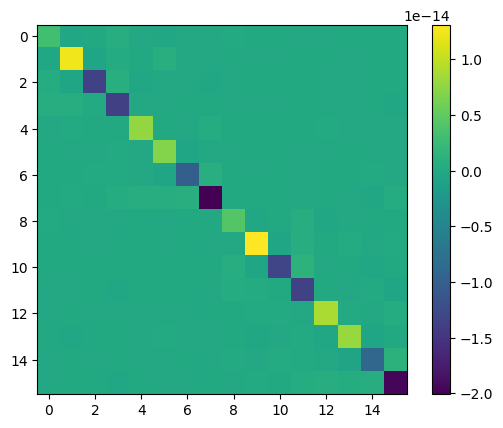

In [17]:
plt.imshow(np.real(mpo.to_dense() @ (U_t.conj().T)) - np.eye(2**N))
plt.colorbar()